This Python code translates the R code (the example_acm.R) into an equivalent plot using ChatGPT. The code creates a scatter plot that displays an adaptive comfort model based on the ASHRAE Global Thermal Comfort Database II. The plot shows the relationship between outdoor temperature and neutral temperature for different building cooling types: Air Conditioned, Mixed Mode, and Naturally Ventilated. </br>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Data preparation
df_acm2 = df_measurements.loc[(~df_measurements['ta'].isna()) &
                              (~df_measurements['thermal_sensation'].isna()) &
                              (~df_measurements['rh'].isna()) &
                              (~(df_measurements['t_out_isd'].isna()) | ~(df_measurements['t_out'].isna()))]

df_acm2['t_out_combined'] = df_acm2['t_out_isd'].combine_first(df_acm2['t_out'])
df_acm2 = df_acm2.drop(columns=['t_out_isd', 't_out'])

df_acm2 = df_acm2.merge(df_meta[['building_id', 'region', 'building_type', 'cooling_type', 'records']], on='building_id', how='left')
df_acm2 = df_acm2[df_acm2['building_type'] == 'office']
df_acm2 = df_acm2.drop(columns=['building_type'])


<ipython-input-3-a2093bc5de5b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acm2['t_out_combined'] = df_acm2['t_out_isd'].combine_first(df_acm2['t_out'])


In [4]:
# Adaptive comfort analysis
def run_lm(group):
    try:
        lm_result = smf.ols(formula='ta ~ thermal_sensation', data=group).fit()
        if lm_result.pvalues['Intercept'] < 0.05:
            return lm_result.params['Intercept']
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

df_models = df_acm2.groupby('building_id').apply(run_lm).reset_index()
df_models.columns = ['building_id', 'neutral_temp']

df_models = df_models.merge(df_meta[['building_id', 'records', 'cooling_type', 'region']], on='building_id', how='left')
df_models['t_out_mean'] = df_acm2.groupby('building_id')['t_out_combined'].mean().values


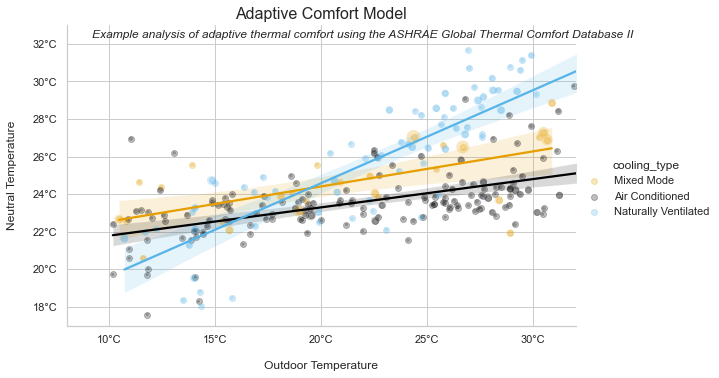

In [25]:
# Visualization
# Assuming df_models is already loaded
filtered_df = df_models[(df_models['t_out_mean'] >= 10) & (df_models['t_out_mean'] <= 33) &
                        (df_models['neutral_temp'] > 17) & (df_models['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()

